# Lipid enrichment around proteins and fingerprints

...

This notebook relies on several modules, notably numpy and matplotlib, as well as the module `taw` that contains a class `TrajectoryWithPBC` for reading in coordinates from a trajectory with PBC using MDAnalysis, and defines several manners to deal with coordinates under periodicity. This seems to be complementary to what Freud offers. The first cell also contains a very simple class for timing different steps, that defines a context with a name, signifying what is being timed. 

In [1]:
import taw
import numpy as np
import math
import matplotlib.pyplot as plt
import glob

/home/chelsea/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Trajectories are read in in series here. The 100\*100 trajectories each have 3.5k frames, which seems overkill.

In [2]:
# ±25s per trajectory with 3.3k frames of 16.4k beads (selecting non water)
# 6 seconds for centering and putting everything in box per trajectory
# ±17s for centering, making compact and aligning
# ±6 seconds for centering and aligning
# ±2 seconds for centering
# ±20 seconds for making compact
timing = taw.Timer()

with timing('Reading trajectories'):
    trjs = [
            taw.TrajectoryWithPBC(
                tpr=f'{i}/md.tpr', 
                trj=f'{i}/md.xtc', 
                selection='not resname W',
                step=10
            ).compact('protein')
        for i in glob.glob('Simulation_*/')
    ]

with timing('Aligning all frames to common reference in xy plane'):
    reference = trjs[0]['protein'][-1].coords
    reference -= reference.mean(axis=0)
    trjs = [ trj.alignxy('protein', reference) for trj in trjs ]

print(timing)

Reading trajectories: 76.48s
Aligning all frames to common reference in xy plane: 3.16s



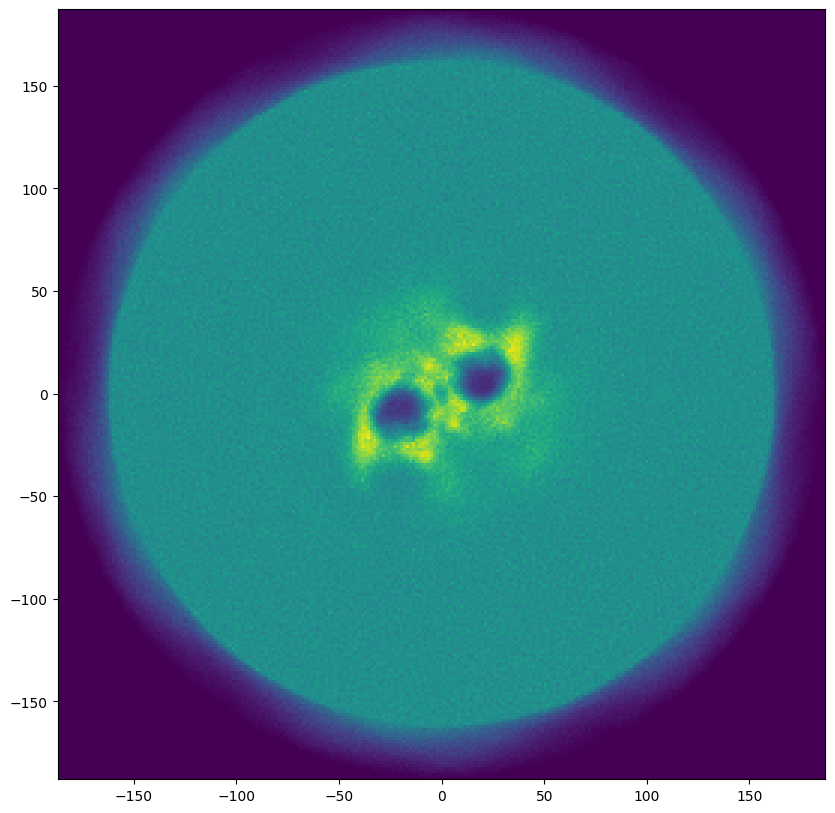

Density plot: 1.55s



In [4]:
with timing('Density plot'):
    plt.subplots(figsize=(10, 10))
    plt.hist2d(*trjs[0][:, :, :2].reshape((-1, 2)).T, bins=256)
    plt.gca().set_aspect('equal')
    plt.show()

print(timing)

In [5]:
# From here not bothering with PBC anymore, 
# but will be using selections
with timing('Selecting lipids'):
    lipids = [ trj['not protein and not resname ION'] for trj in trjs ]
    
with timing('Selecting protein'):
    protein = [ trj['protein'] for trj in trjs ]

with timing('Getting backbone'):
    backbone = [ trj['name BB'] for trj in trjs ]

print(timing)

Selecting lipids: 4.32s
Selecting protein: 0.49s
Getting backbone: 0.33s



## Determining the membrane center

The membrane center is here determined for the whole cell. 

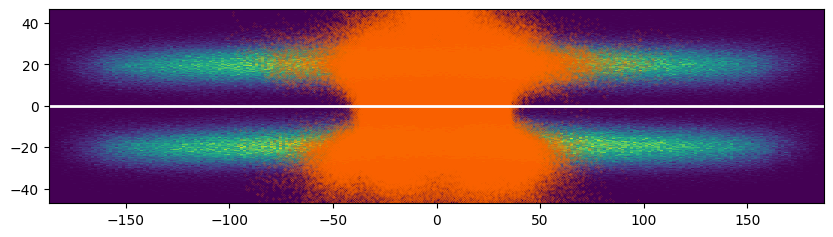

Centering everything on mean membrane z: 0.17s
Plot: 0.68s



In [6]:
with timing('Centering everything on mean membrane z'):
    for lip, prot in zip(lipids, backbone):
        mid = lip.coords[:, :, 2].mean(axis=1)
        lip[:, :, 2] -= mid[:, None]
        prot[:, :, 2] -= mid[:, None]

with timing('Plot'):
    plt.subplots(figsize=(10, 10))
    #plt.hist2d(*lipids[0].coords[:, :, 1:].reshape((-1, 2)).T, bins=256)
    plt.hist2d(*lipids[0]['name PO4'].coords[:, :, 1:].reshape((-1, 2)).T, bins=256)
    plt.scatter(*backbone[0].coords[:, :, 1:].reshape((-1, 2)).T, s=0.01, c='#f60')
    #plt.plot(*backbone[0].coords[:, :, 1:].reshape((-1, 2)).T, c='#f60')
    plt.axhline(0, linewidth=2, c='white')
    plt.gca().set_aspect('equal')
    plt.show()
    
print(timing)

In [7]:
with timing('Splitting lipids in single species'):
    lipids = {
        species: [ t[f'resname {species}'] for t in lipids ]
        for species in set(lipids[0].universe.atoms.resnames)
    }
timing

Splitting lipids in single species: 4.27s

In [9]:
colormaps = { 'CDL2':'RdPu', 'SAPE':'Greens', 'POPS':'YlGn','POPC':'Purples','PAPI':'YlOrBr', 'CHOL':'PuRd','PCER':'GnBu' }

PuRd


This next cell is to break the lines for large distances

In [10]:
with timing('Cut subunits: '):
    distances = np.append(np.diff(backbone[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T[1]),0)
    backbone_plot = backbone[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T
    discont_indices =  np.abs(distances) > 4
    discont_indices_2 = np.abs(distances) < -4
    backbone_plot[1][discont_indices] = np.nan
    backbone_plot[1][discont_indices_2] = np.nan
    distances_2 = np.append(np.diff(backbone[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T[0]),0)
    discont_indices_3 =  np.abs(distances_2) > 4
    discont_indices_4 = np.abs(distances_2) < -4
    backbone_plot[0][discont_indices_3] = np.nan
    backbone_plot[0][discont_indices_4] = np.nan

print(timing)

Chelseas silly way to cut subunits: : 0.03s



PAPI


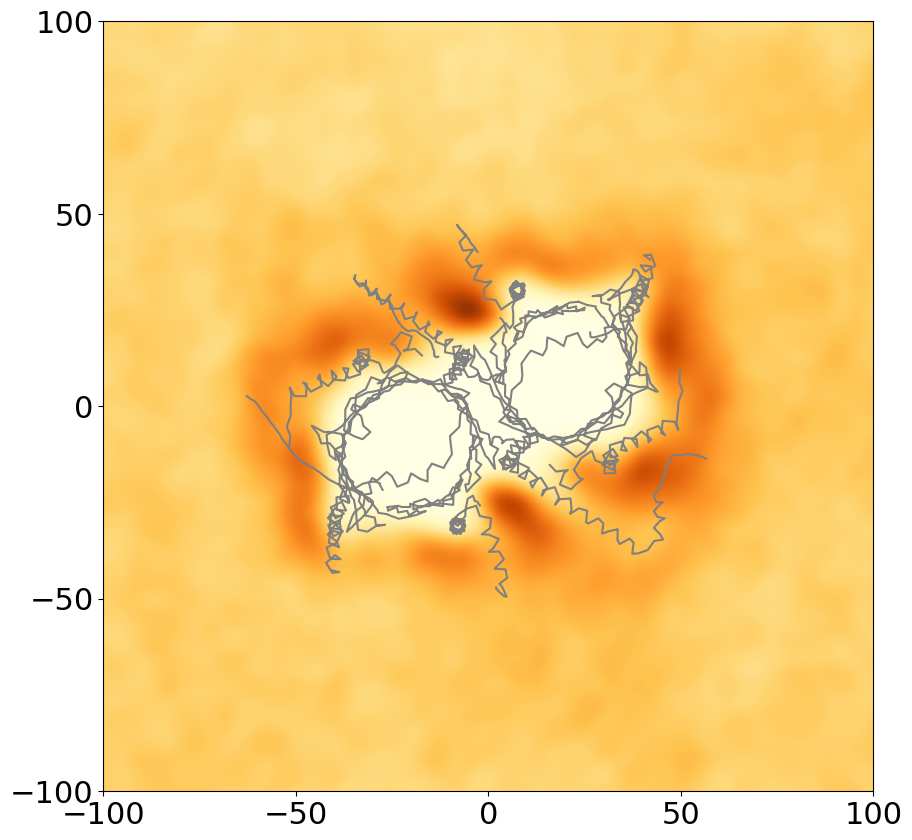

SAPE


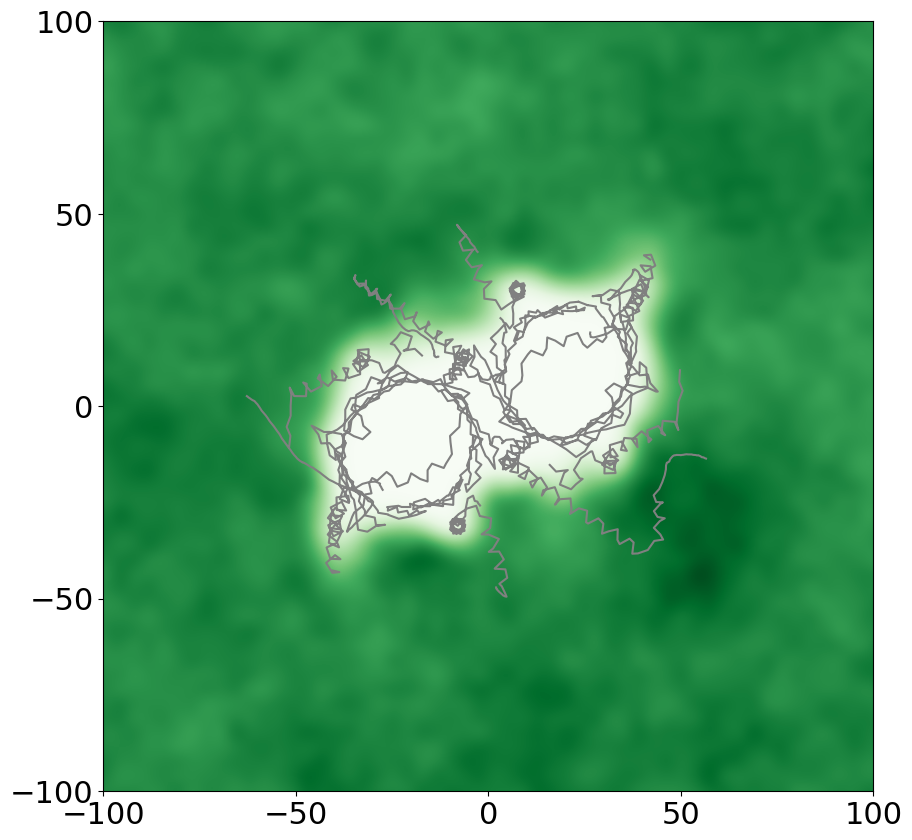

POPC


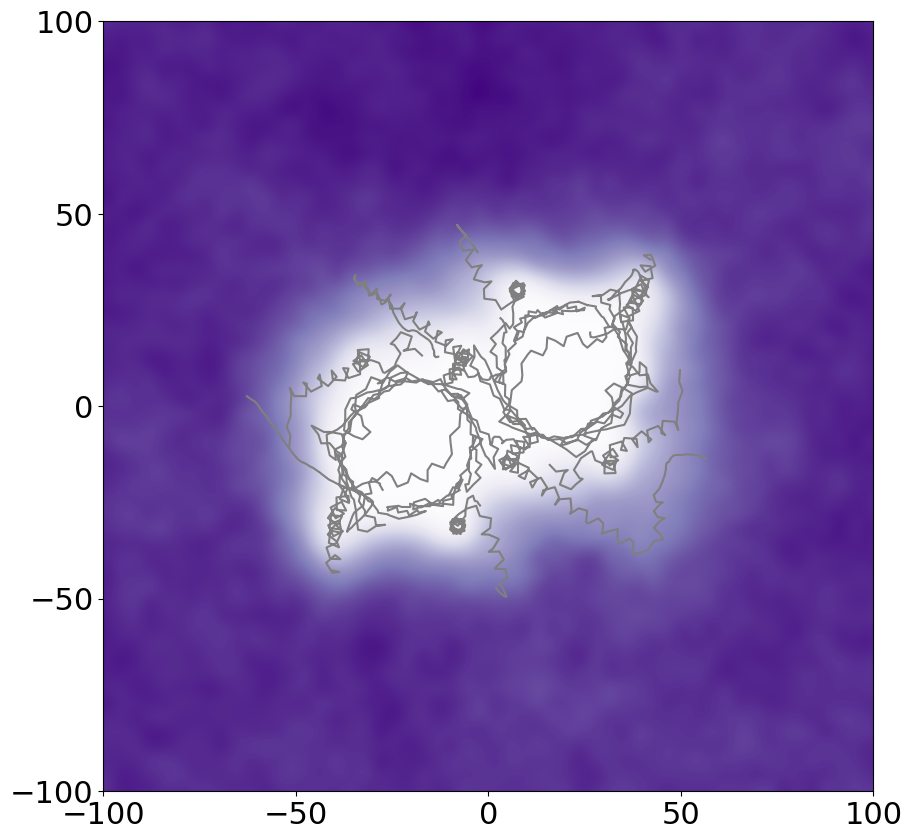

PCER


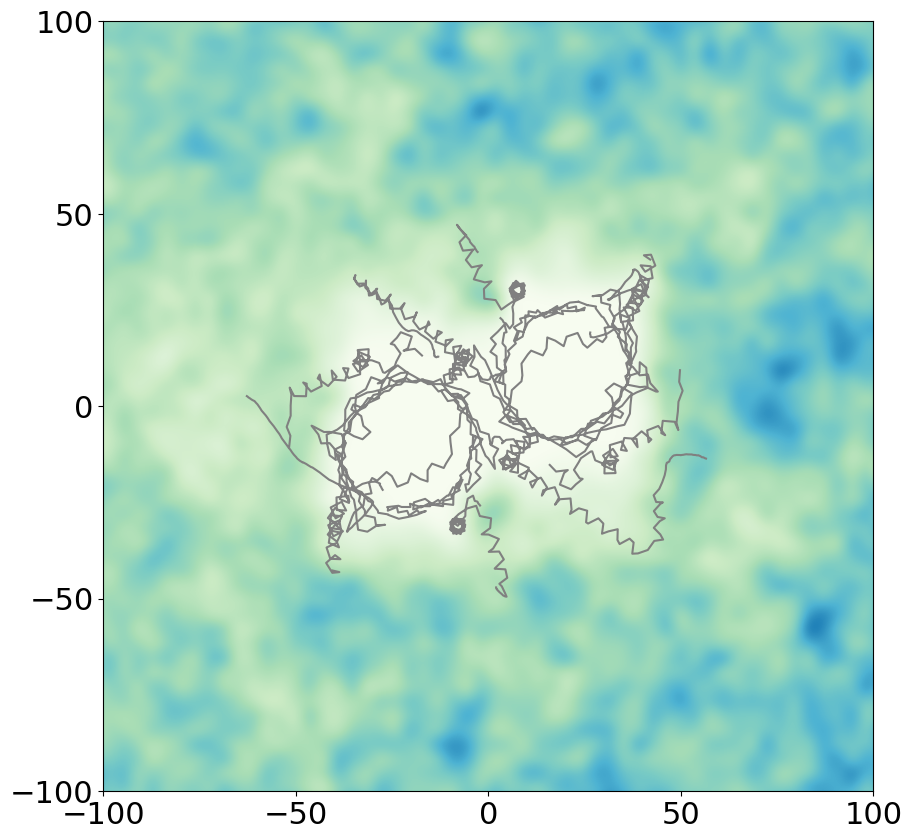

CHOL


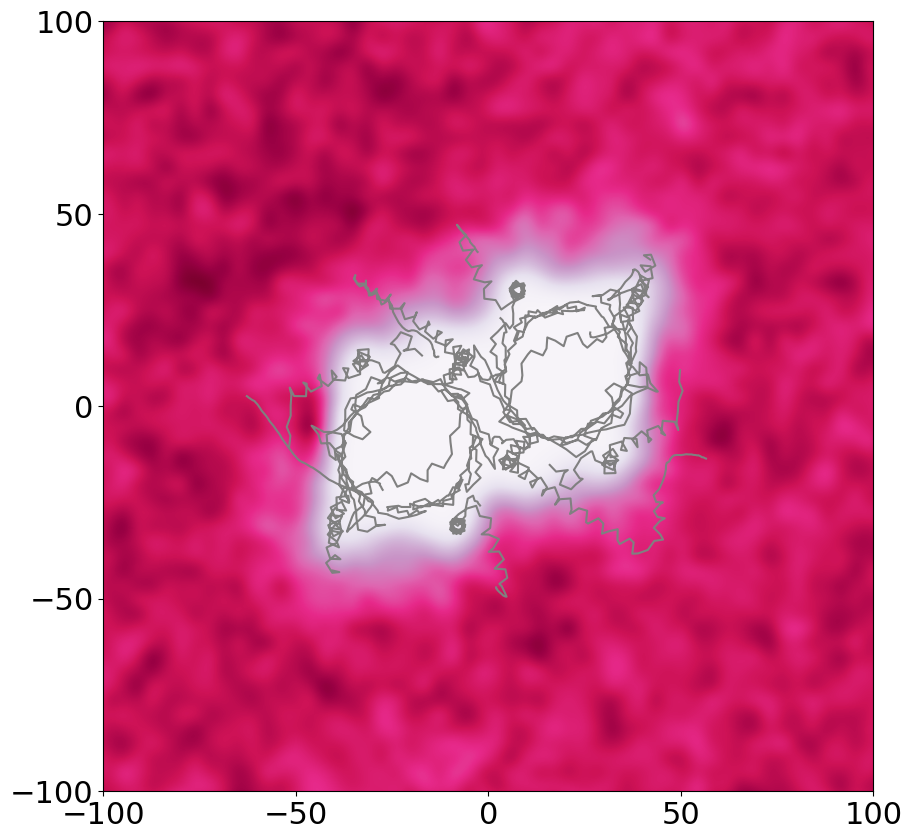

Plot all: 12.91s



In [11]:
plt.rcParams.update({'font.size': 22})
with timing('Plot all'):
    for lip, lipco in lipids.items():
        print(lip)
        plt.subplots(figsize=(10, 10))
       
        #plt.hist2d(
        #    *lipco[0].coords[:, :, :2].reshape((-1, 2)).T, 
        #    bins=250, cmap='RdPu')#, range=((-100, 100), (-40, 40)))
        array_op,xedges,yedges = np.histogram2d(*lipco[0].coords[:, :, :2].reshape((-1, 2)).T, bins=100)
        max_array=max(array_op.flatten())
        array_avg = array_op/max_array
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1] ]
        plt.imshow(array_avg.T, interpolation='bicubic',extent=extent,origin='lower', cmap=colormaps[lip])
        #plt.scatter(*protein[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T, s=1, c='#fc0')
        #plt.plot(*backbone[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T, c='gray')
        plt.plot(*backbone_plot, c='gray')
        #plt.axhline(0, linewidth=2, c='white')
        plt.gca().set_aspect('equal')
        plt.ylim(-100, 100)
        plt.xticks(np.arange(-100, 101, step=50))
        plt.xlim(-100,100)
        plt.yticks(np.arange(-100, 101, step=50))
        plt.savefig(f'{lip}_density_xy.png', dpi=400)
        plt.show()
        
print(timing)

In [12]:
with timing('Cut subunits: '):
    distances = np.append(np.diff(backbone[0].coords[:, :, 1:3].mean(axis=0).reshape((-1, 2)).T[1]),0)
    backbone_plot_side  = backbone[0].coords[:, :, 1:3].mean(axis=0).reshape((-1, 2)).T
    discont_indices =  np.abs(distances) > 4
    discont_indices_2 = np.abs(distances) < -4
    backbone_plot_side[1][discont_indices] = np.nan
    backbone_plot_side[1][discont_indices_2] = np.nan
    distances_2 = np.append(np.diff(backbone[0].coords[:, :, 1:3].mean(axis=0).reshape((-1, 2)).T[0]),0)
    discont_indices_3 =  np.abs(distances_2) > 4
    discont_indices_4 = np.abs(distances_2) < -4
    backbone_plot_side[0][discont_indices_3] = np.nan
    backbone_plot_side[0][discont_indices_4] = np.nan

print(timing)

Chelseas silly way to cut subunits: : 0.03s



PAPI


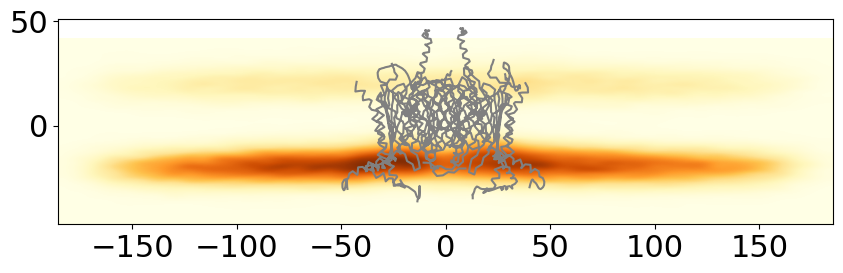

SAPE


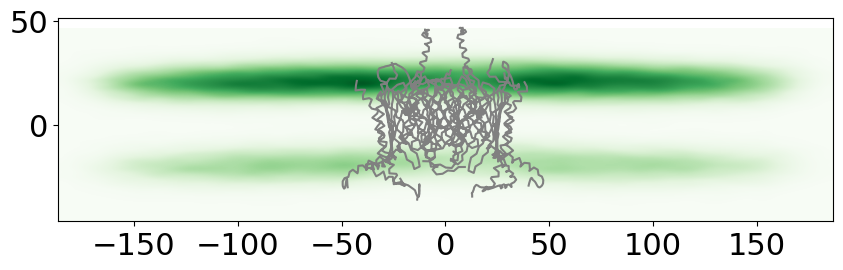

POPC


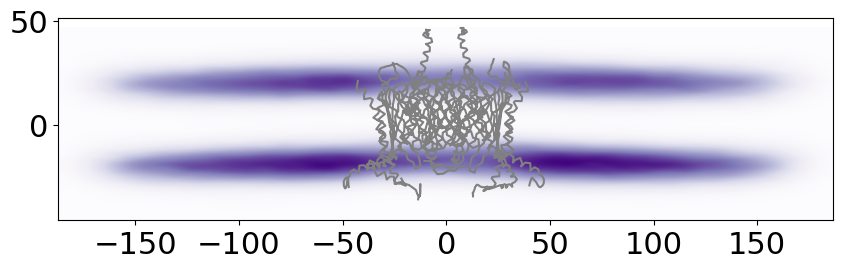

PCER


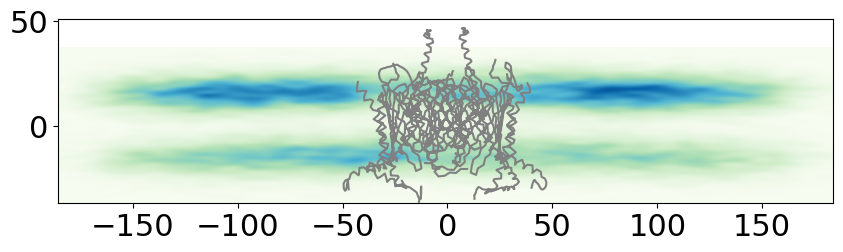

CHOL


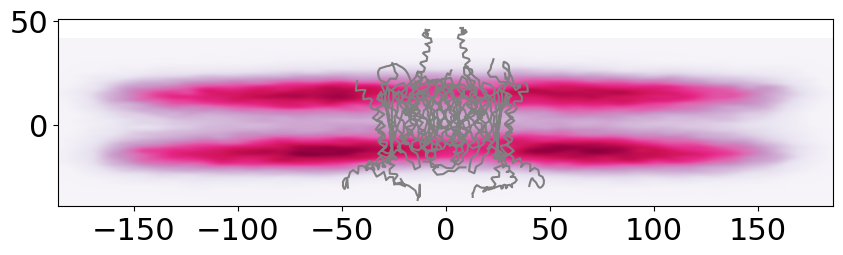

Plot all: 5.01s



In [13]:
with timing('Plot all'):
    for lip, lipco in lipids.items():
        print(lip)
        plt.subplots(figsize=(10, 10))
        #plt.hist2d(
        #    *lipco[0].coords[:, :, :2].reshape((-1, 2)).T, 
        #    bins=250, cmap='RdPu')#, range=((-100, 100), (-40, 40)))
        array_op,xedges,yedges = np.histogram2d(*lipco[0]['name PO* ROH OH1'].coords[:, :, 1:3].reshape((-1, 2)).T, bins=50)
        max_array=max(array_op.flatten())
        array_avg = array_op/max_array
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1] ]
        plt.imshow(array_avg.T, interpolation='bicubic',extent=extent,origin='lower', cmap=colormaps[lip])
        #plt.scatter(*protein[0].coords[:, :, :2].mean(axis=0).reshape((-1, 2)).T, s=1, c='#fc0')
        #plt.plot(*backbone[0].coords[:, :, 1:3].mean(axis=0).reshape((-1, 2)).T, c='gray')
        plt.plot(*backbone_plot_side, c='gray')
        #plt.axhline(0, linewidth=2, c='white')
        plt.gca().set_aspect('equal')
        plt.savefig(f'{lip}_density_xz.png', dpi=400)
        plt.show()
        
print(timing)